# 環境の確認とデータセットの読み出し

以降では、Pythonの機械学習用ライブラリーであるscikit-learnを利用するため、
バージョンを確認しておきます。

0.21以上であれば、以降のプログラムを実行することが可能なはずです。

また、著者当てゲームの特徴抽出済みのデータセットを読み出します。

In [1]:
 # ライブラリーのインポート
import sklearn
print(sklearn.__name__, sklearn.__version__)
import numpy as np
print(np.__name__, np.__version__)
import matplotlib.pyplot as plt
import japanize_matplotlib
import math
import random
import pandas as pd

# データセットの読み出し
akutagawa_name = np.load('data/akutagawa_name.npy', allow_pickle=True)
kikuchi_name = np.load('data/kikuchi_name.npy', allow_pickle=True)
hgram = np.load('data/hgram.npy', allow_pickle=True)
words = np.load('data/words.npy', allow_pickle=True)
print('芥川龍之介の作品は以下の20編')
print(' '.join(akutagawa_name))
print('\n菊池寛の作品は以下の20編')
print(' '.join(kikuchi_name))
print('\n40編の作品に現れる語の総数は{}語'.format(len(words)))

sklearn 1.0.2
numpy 1.22.1
芥川龍之介の作品は以下の20編
羅生門 妖婆 藪の中 貉 鼻 歯車 トロッコ 杜子春 俊寛 侏儒の言葉 邪宗門 将軍 死後 アグニの神 或る日の大石内蔵助 おぎん お時儀 河童 煙管 蜘蛛の糸

菊池寛の作品は以下の20編
姉川の戦い ある恋の話 入れ札 M公爵と写真師 屋上の狂人 恩讐の彼方に 女強盗 恩を返す話 義民甚平 勲章を貰う話 極楽 出世 勝負事 大力の物語 藤十郎の恋 ある抗議書 身投げ救助業 無名作家の日記 若杉裁判長 奉行と人相学

40編の作品に現れる語の総数は16307語


### 2.7.2 交差検証(Cross Validation)
次の設定で著者当てゲームに取り組む者とします。
- ユークリッド距離によりデータの（非）類似度を測定
- k-NNアルゴリズムで分類

**40個の作品データを訓練データ**として学習し、
**同じ40個のデータをテストデータ**として、
学習の結果生成されたモデルの予測性能を評価します。


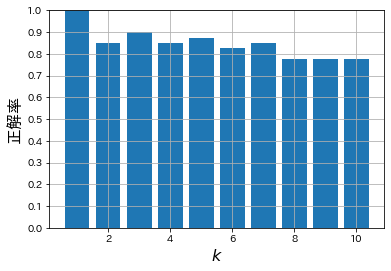

In [2]:
# ハイパーパラメータの値と正解率の関係を得る
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore", FutureWarning)


def dl2(dictx, dicty):
    sq = 0
    for key in set(dictx.keys()) | set(dicty.keys()):
        x, y = 0, 0
        if key in dictx: 
            x = dictx[key]
        if key in dicty:
            y = dicty[key]
        sq += (x - y)**2
    return math.sqrt(sq)

temp = [] 
for dictx in hgram:
    temp.append(list(map(lambda dicty: dl2(dictx, dicty), hgram)))
dl2_matrix = np.array(temp) # 距離の行列

l1 = len(akutagawa_name)
l2 = len(kikuchi_name)
labels = np.array([0]*l1 + [1]*l2)

y = []
for k in range(1, 11):
    clf = KNeighborsClassifier(metric='precomputed', n_neighbors=k)
    clf.fit(dl2_matrix, labels)
    pred = clf.predict(dl2_matrix)
    y.append(accuracy_score(labels, pred))

# ハイパーパラメータの値と正解率の関係の可視化
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('$k$', fontsize=16)
plt.ylabel('正解率', fontsize=16)
plt.bar(range(1, 11), y)
plt.grid()
plt.show()

正解率は、$k = 1$の時に1.0、$k = 3$の時に0.9となり、
一見うまくいっているように見えます。

しかし、この一見よい結果は、**カンニング効果**、つまり、
試験問題の答えを予め知っていたことによるものです。

つまり、正確な予測性能の評価を行うためには、
**訓練データと異なるテストデータで評価しなければならない**
という原則があるのですが、
この原則に従わなかったことから不適切に高い正解率が得られた訳です。

利用できるデータ数に限りがあるとき、次のような問題が起こります。

- 訓練データが少ないと、学習が十分に行われず、予測性能が低くなる
- テストデータが少ないと、偶然により予測の分布が偏る可能性があり、評価の信頼性が低くなる

データセットを互いに交わりのない訓練データとテストデータに分割すると、
訓練データを多く取ればテストデータが少なくなり、
逆に、テストデータを多く取れば訓練データが少なくなります。
つまり、利用できるデータ数が少ない時は、
**予測の正確性と正解率の信頼性は互いに二律背反の関係にある**ということです。

40個のデータでは少ないので、それぞれ100個の訓練データとテストデータを新たに作成して、
訓練データとテストデータの個数が少ない時の弊害を具体的に見てみます。

赤（ラベル0）と青（ラベル1）で塗り分けられた領域から、
ランダムに200個のデータを選択して、
このシミュレーションで利用するデータセットとします。

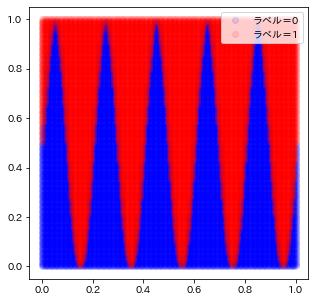

In [3]:
def get_label(x, y):
    if y < 0.5 * (np.sin(10*np.pi*x) + 1):
        return 0
    return 1

xp = []
yp = []
xn = []
yn = []

for x in np.linspace(0, 1, 201):
    for y in np.linspace(0, 1, 201):
        if get_label(x, y) ==0:
            xp.append(x)
            yp.append(y)
        else:
            xn.append(x)
            yn.append(y)
plt.figure(figsize = (5,5))
plt.scatter(xp, yp, c = 'b', alpha = 0.1, label='ラベル＝0')
plt.scatter(xn, yn, c = 'r', alpha = 0.1, label='ラベル＝1')
plt.legend()
plt.show()

次のセルを実行すると、
訓練データ数を数個から100個まで増やして行くに従って、
100個のテストデータから計算した正解率が高くなっていく様子が観察できると思います。

多くの訓練データを用いることで予測性能が改善されていくことを示しています。

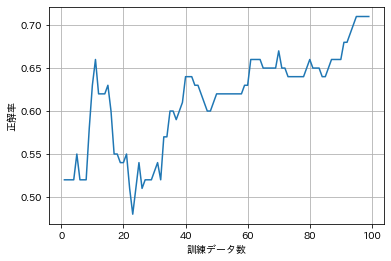

In [5]:
n = 100
train_d = np.random.rand(n, 2)
train_l = np.array([get_label(x, y) for x, y in train_d])
test_d = np.random.rand(n, 2)
test_l = np.array([get_label(x, y) for x, y in test_d])

clf = KNeighborsClassifier(metric='euclidean', n_neighbors=1)
y = []
for m in range(1, n):
    clf.fit(train_d[:m],train_l[:m])
    pred = clf.predict(test_d)
    y.append(accuracy_score(test_l, pred))

plt.plot(range(1, n), y)
plt.xlabel('訓練データ数')
plt.ylabel('正解率')
plt.grid()
plt.show()

逆に、100個のデータで訓練を行った後、1個から100個のテストデータを用いて正解率を測定した結果を示します。

テストデータの個数が少ない時には正解率の値は乱高下するのに対し、
ですとデータの個数が増えるに従い正解率の値が収束していく様子が観察できると思います。

テストデータの個数が少ないと、偶然により予測結果が偏ることが原因です。

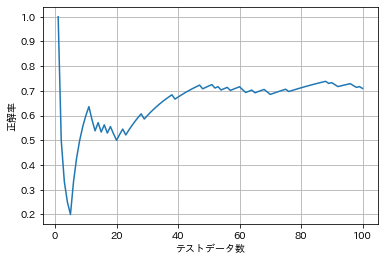

In [6]:
clf.fit(train_d,train_l)
pred = clf.predict(test_d)
y = [accuracy_score(test_l[:m], pred[:m]) for m in range(1, n+1)]

plt.plot(range(1, n+1), y)
plt.xlabel('テストデータ数')
plt.ylabel('正解率')
plt.grid()
plt.show()

利用できるデータ数が少ない時に、
可能な限り学習を進め、かつ、予測の偏りを抑制するために有効な方法として、
**交差検証法**が知られています。


#### 交差検証

「**予測の正確性と正解率の信頼性の間の二律背反**」を解消します。\
実際に以下の例に従って、交差検証を実装してみましょう。

---
**例.** 5分割交差検証
> 1. データセットをランダムに5群に分割
> 1. 5群のうち1群をテストデータに指定
> 1. 残り４群を訓練データとして学習
> 1. テストデータに対してクラスを予想
> 1. テストデータ群を取り替えて2.〜4.を5回実行

ではまず、ランダムに5群に分割します。

In [7]:
# ランダムに5群に分割
import random
name = np.hstack([akutagawa_name, kikuchi_name]) # 40作品すべてのタイトルのリスト生成

a_index = list(range(20)) # 芥川の作品は20(番号と作品が結びつけたい)
random.shuffle(a_index) # ランダムにシャッフル
a_partition = [a_index[4*n:4*n+4] for n in range(5)] # 芥川の20作品を四つずつ、5グループに分けてリストにする
k_index = list(range(20, 40))
random.shuffle(k_index)
k_partition = [k_index[4*n:4*n+4] for n in range(5)]
partition = [a_partition[n] + k_partition[n] for n in range(5)] # 前半四つが芥川、後半四つが菊池の作品番号を持つリストを合計五つ持つリスト
y_test = [0]*4 + [1]*4

dict = {}
dict['グループ'] = np.array([[i]*8 for i in range(5)]).flatten()
dict['正解'] = ['芥川' if t == 0 else '菊池' for t in y_test*5]
dict['予測'] = ['']*40
df = pd.DataFrame(dict, index = [name[n] for n in np.array(partition).flatten()])
display(df)

,グループ,正解,予測
死後,0,芥川,
妖婆,0,芥川,
或る日の大石内蔵助,0,芥川,
俊寛,0,芥川,
勝負事,0,菊池,
身投げ救助業,0,菊池,
大力の物語,0,菊池,
奉行と人相学,0,菊池,
藪の中,1,芥川,
歯車,1,芥川,


試しに予測には、$k = 1$として、$k$-NNアルゴリズムを用います。

第0群をテストデータとし、残り4群を訓練データとして学習を行った後、テストデータのクラスを予測してみます。

In [8]:
from functools import reduce
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(metric='precomputed', n_neighbors=1)

prediction = []

y_test = [0]*4 + [1]*4
y_train = y_test*4

i = 0
index_train = reduce(lambda a, b: a+b, 
                     [partition[n] for n in range(5) if n != i])
dl2_train = dl2_matrix[index_train][:, index_train]
dl2_test = dl2_matrix[partition[i]][:, index_train]

clf.fit(dl2_train, y_train)
prediction.append(clf.predict(dl2_test))


for j in range(8):
    df.at[name[partition[i][j]], '予測'] = '芥川' if prediction[i][j] == 0 else '菊池'
display(df)

,グループ,正解,予測
死後,0,芥川,芥川
妖婆,0,芥川,菊池
或る日の大石内蔵助,0,芥川,芥川
俊寛,0,芥川,芥川
勝負事,0,菊池,芥川
身投げ救助業,0,菊池,芥川
大力の物語,0,菊池,菊池
奉行と人相学,0,菊池,芥川
藪の中,1,芥川,
歯車,1,芥川,


次に、1群をテストデータとし、残り4群を訓練データとして学習を行い、テストデータのクラスを予測します。

In [9]:
i = 1
index_train = reduce(lambda a, b: a+b, 
                     [partition[n] for n in range(5) if n != i])
dl2_train = dl2_matrix[index_train][:, index_train]
dl2_test = dl2_matrix[partition[i]][:, index_train]

clf.fit(dl2_train, y_train)
prediction.append(clf.predict(dl2_test))

for j in range(8):
    df.at[name[partition[i][j]], '予測'] = '芥川' if prediction[i][j] == 0 else '菊池'
display(df)

,グループ,正解,予測
死後,0,芥川,芥川
妖婆,0,芥川,菊池
或る日の大石内蔵助,0,芥川,芥川
俊寛,0,芥川,芥川
勝負事,0,菊池,芥川
身投げ救助業,0,菊池,芥川
大力の物語,0,菊池,菊池
奉行と人相学,0,菊池,芥川
藪の中,1,芥川,菊池
歯車,1,芥川,芥川


同様に、2群をテストデータとし、残り4群を訓練データとして学習を行い、テストデータのクラスを予測します。

In [10]:
i = 2
index_train = reduce(lambda a, b: a+b, 
                     [partition[n] for n in range(5) if n != i])
dl2_train = dl2_matrix[index_train][:, index_train]
dl2_test = dl2_matrix[partition[i]][:, index_train]

clf.fit(dl2_train, y_train)
prediction.append(clf.predict(dl2_test))

for j in range(8):
    df.at[name[partition[i][j]], '予測'] = '芥川' if prediction[i][j] == 0 else '菊池'
display(df)

,グループ,正解,予測
死後,0,芥川,芥川
妖婆,0,芥川,菊池
或る日の大石内蔵助,0,芥川,芥川
俊寛,0,芥川,芥川
勝負事,0,菊池,芥川
身投げ救助業,0,菊池,芥川
大力の物語,0,菊池,菊池
奉行と人相学,0,菊池,芥川
藪の中,1,芥川,菊池
歯車,1,芥川,芥川


3群をテストデータとし、残り4群を訓練データとして学習を行い、テストデータのクラスを予測します。

In [11]:
i = 3
index_train = reduce(lambda a, b: a+b, 
                     [partition[n] for n in range(5) if n != i])
dl2_train = dl2_matrix[index_train][:, index_train]
dl2_test = dl2_matrix[partition[i]][:, index_train]

clf.fit(dl2_train, y_train)
prediction.append(clf.predict(dl2_test))

for j in range(8):
    df.at[name[partition[i][j]], '予測'] = '芥川' if prediction[i][j] == 0 else '菊池'
display(df)

,グループ,正解,予測
死後,0,芥川,芥川
妖婆,0,芥川,菊池
或る日の大石内蔵助,0,芥川,芥川
俊寛,0,芥川,芥川
勝負事,0,菊池,芥川
身投げ救助業,0,菊池,芥川
大力の物語,0,菊池,菊池
奉行と人相学,0,菊池,芥川
藪の中,1,芥川,菊池
歯車,1,芥川,芥川


4群をテストデータとし学習を行い、残り4群を訓練データとして、テストデータのクラスを予測します。

In [12]:
i = 4
index_train = reduce(lambda a, b: a+b, 
                     [partition[n] for n in range(5) if n != i])
dl2_train = dl2_matrix[index_train][:, index_train]
dl2_test = dl2_matrix[partition[i]][:, index_train]

clf.fit(dl2_train, y_train)
prediction.append(clf.predict(dl2_test))

for j in range(8):
    df.at[name[partition[i][j]], '予測'] = '芥川' if prediction[i][j] == 0 else '菊池'
display(df)

,グループ,正解,予測
死後,0,芥川,芥川
妖婆,0,芥川,菊池
或る日の大石内蔵助,0,芥川,芥川
俊寛,0,芥川,芥川
勝負事,0,菊池,芥川
身投げ救助業,0,菊池,芥川
大力の物語,0,菊池,菊池
奉行と人相学,0,菊池,芥川
藪の中,1,芥川,菊池
歯車,1,芥川,芥川


以上の交差検証では、
- **32個の訓練データによる学習を5回実施**
- **40個全てのデータに対して予測を実施**

することで、
モデルの予測性能の信頼性を担保します。

$k$分割交差検証は次の性質を持ちます。
- $k$が大きいほど、評価の信頼性は高くなります。
- $k$回学習を行うので、$k$が大きいと評価に時間がかかります。

**各グループが1個のデータのみを含む**時、
評価の信頼性は最大になります。
この方法を**LOO法**（leave one out）と呼びます。

1回の学習に時間がかかるような場合は、
評価に要する時間と評価の信頼性を天秤にかけ、
$k = 3, 5, 10$など適切な$k$の値を選択します。